Name: Samuel Olusegun \.
CHE5382 Project 1

In [1]:
#import the rquired libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#define the given conditions (box length, density, number of shells, number of particles, maximum distance)
box_L = 12
rho = 0.78
num_shells = 60
num_part = int(rho*box_L**3)
max_dist = box_L/2
#r = np.linspace(0.01,3.0,num=600)
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
Rcutoff = 2.5 #cutoff for truncation
T0=1.25

In [4]:
box_length = box_L  # Length of the cubic cell
density = rho

# Calculate the number of particles
volume = box_length**3
num_particles = int(density * volume)

# Generate positions for a simple cubic lattice
# Assuming particles are evenly spaced along each axis
#n_side = int(np.cbrt(num_particles))  # Number of particles along one side
#spacing = box_length / n_side  # Spacing between particles
n_side = 12
spacing = box_L/n_side
# Generate particle positions for the lattice
particle_positions = []
for x in range(n_side):
    for y in range(n_side):
        for z in range(n_side):
            if len(particle_positions)< num_particles:
                particle_positions.append([x * spacing + spacing/2, 
                                           y * spacing + spacing/2, z * spacing+ spacing/2])
particle_positions = np.array(particle_positions)- box_L/2
print('The total number of particles is: ',len(particle_positions))
tri_up=np.transpose(np.tri(len(particle_positions), dtype=int, k=-1))
zero_diag= np.ones((num_part,num_part), dtype=int) 
zero_diag[np.diag_indices(num_part)] = 0 

The total number of particles is:  1347


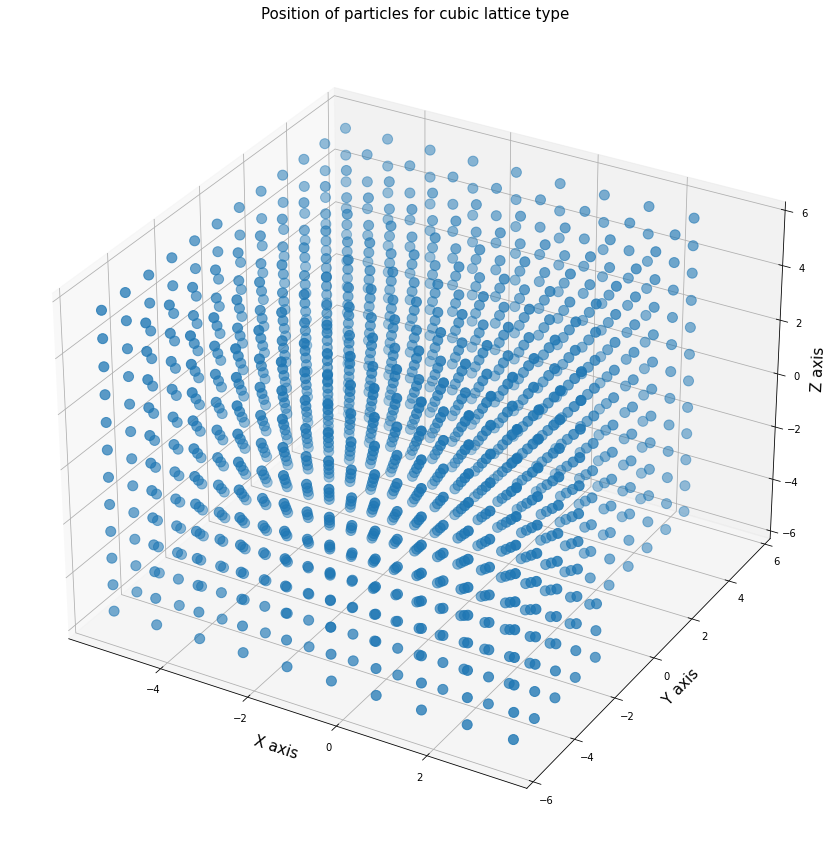

In [5]:
#plot the generated particle positions
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(particle_positions[:,0],particle_positions[:,1],particle_positions[:,2], marker='o',s=100)
ax.set_xlabel('X axis', fontsize=15)
ax.set_ylabel('Y axis', fontsize=15)
ax.set_zlabel('Z axis', fontsize=15)
plt.title('Position of particles for cubic lattice type', fontsize=15)
plt.show()

In [6]:
#function to calculate the RDF for an ideal gas with the given conditions
def ideal_rdf(num_shells, rho, r, num_part):
    Id_rdf = np.zeros(num_shells)
    ri_list = np.zeros(num_shells)
    dr = r/num_shells          #thickness of shell
    for i in range(len(Id_rdf)):
        ri=i/(num_shells/max_dist) + 0.5*dr # radius r is at the center of each shell
        Id_rdf[i]=4*np.pi*(ri**2)*dr*rho * num_part   #g(r)_ideal = V *N/V * 4*pi*r^2*dr*rho
        ri_list[i]=ri
    return ri_list,Id_rdf

In [7]:
#function to calculate the RDF of a randomly distributed particle
def calc_rdf(num_shells, r, co_od, num_part):
    Id_rdf = np.zeros(num_shells)
    for i in range(num_part):             # calculate n(n-1)/2 distances
        for j in range(i + 1, num_part):
            posi = co_od[i]
            posj = co_od[j]
            RIJ = posi -posj
            # calculate the minimum image distance assumming periodic boundary condition
            min_RIJ = RIJ - box_L*np.floor(RIJ/box_L+0.5)   
            min_RIJ2 = min_RIJ * min_RIJ
            dr = np.sqrt( min_RIJ2.sum() ) # calculate the distances
            if dr < r:      #if the distance is within the needed range (half the box length), add to g(r)
                shell = int(dr * (num_shells/max_dist))  
                Id_rdf[shell] += 2    #count in pairs
    return Id_rdf

In [8]:
#function to calculate the RDF/RDF_ideal
def get_g(num_part,num_shells, r, co_od,rho):
    dr,Id_rdf = ideal_rdf(num_shells,rho,box_L/2, num_part)  
    cal_rdf = calc_rdf(num_shells,box_L/2,co_od,num_part)
    g = np.zeros(num_shells)
    for i in range(len(g)):
        g[i]=cal_rdf[i]/(Id_rdf[i])     #g(r) = N(r)/N(r)_ideal
    init = np.zeros(1)
    ri = np.concatenate((init,dr))   #Use (0,0) as the starting point
    g_r = np.concatenate((init,g))
    return ri,g_r,dr,Id_rdf,cal_rdf

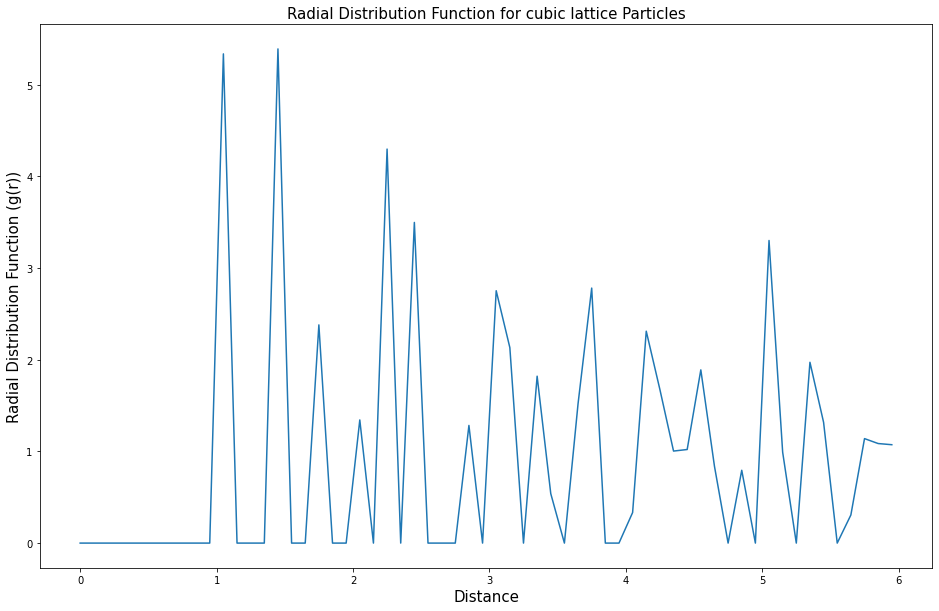

In [9]:
#Ploting the RDF for the initial lattice configuration
num_shells=box_L*5
r=box_L/2
co_od = np.array(particle_positions)
ri,g_r,dr,Id_rdf,cal_rdf = get_g(num_part,num_shells, r, co_od,rho)
plt.figure(figsize=(16,10))
plt.plot(ri, g_r)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Radial Distribution Function (g(r))', fontsize=15)
plt.title('Radial Distribution Function for cubic lattice Particles', fontsize=15)
plt.show()

In [147]:
#function to generate initial velocity of atoms at the given reduced temperature T0
T0=1.25
def initial_vel(num_part):
    a=np.sqrt(12*T0)
    np.random.seed(5)  
    v_0 = np.random.uniform(low=-a/2, high=a/2, size=(num_part,3))
    return v_0

In [11]:
#function to return minimum distances(rij) and minimum displacement on each axis(xij,yij,zij)
def distance_matrix(particle_positions,box_L):
    a=np.resize(particle_positions,[num_part,num_part,3])
    aT=np.transpose(a,(1,0,2))
    d=aT-a
    min_d=(d - box_L*np.floor(d/box_L+0.5))
    r=np.sqrt(np.sum(np.square(min_d),axis=2))
    return r,min_d

In [138]:
#Verlet Neighbor list function (for bonus point)
def verlet_neighbor(eu_dis1,rad):
    Vn_list=np.where(eu_dis1 > rad, 0, 1)
    Vn_list[np.diag_indices(num_part)] = 0
    return Vn_list

In [13]:
#function to return Potential enery(PE) and Forces (summation and piecewise) 
def E_F(eu_dist,min_dis):
    cut= verlet_neighbor(eu_dist,Rcutoff)
    mat=tri_up*cut
    eu_dist[eu_dist == 0] = 1
    E_L= np.sum((4*((mat/eu_dist)**12-(mat/eu_dist)**6)-(mat*E_shift)))
    Fij=cut*((24/eu_dist**8)*((2/eu_dist**6)-1)-F_shift)
    F=np.stack([Fij] * 3, axis=-1)*min_dis
    force=np.sum(F, axis=1)
    return E_L,force,F

In [145]:
#The initial Potential Energy Of the system
E_F(eu_dis,min_d)[0]

-4115.292005847497

In [14]:
#function to return the new position of particles in the system
def new_position(old_pos,t,old_v,acce):
    new=old_pos + t*old_v + 0.5*(t**2)*acce
    new_pos=(new - box_L*np.floor(new/box_L+0.5))
    return new_pos

In [15]:
#function to return new velocity, Kinetic & Total Energy, and Temperature of system
def velocity_vel(old_v,t,old_acce,new_acce,P_E):
    new_v=old_v+0.5*t*(old_acce+new_acce)
    #new_v=new_v-np.average(new_v,axis=0)
    Temp=np.sum(np.square(new_v))/(3*num_part)
    KE=0.5*np.sum(np.square(new_v))
    #KE=1.5*Temp*num_part
    TE=KE+P_E
    return new_v,Temp,KE,TE

In [142]:
eu_dis,min_d=distance_matrix(particle_positions,box_L)
E_shift=(4.0/(Rcutoff**12)-4.0/(Rcutoff**6))
F_shift=24*(2/Rcutoff**13 - 1/Rcutoff**7)*0  #no force correction
t=0.003 #define magnitude of time step
v0=initial_vel(num_part)

In [148]:
#function to implement the Molecular dynamics simulation
def MD(particle_positions):
    Data_list = []
    position_list = []
    ini_pos=particle_positions.copy()
    ini_vel=initial_vel(num_part)
    ini_r,ini_x=distance_matrix(particle_positions,box_L)
    ini_PE,ini_F,a=E_F(ini_r,ini_x)
    take_pos=0
    verlet=0
    for i in range(120000):
        if i>verlet:
            verlet_neighbor(ini_r,3)
            verlet+=10
        new_pos=new_position(ini_pos,t,ini_vel,ini_F)
        new_r,new_x=distance_matrix(new_pos,box_L)
        new_PE,new_F,b=E_F(new_r,new_x)
        new_vel,Temp,new_KE,new_TE=velocity_vel(ini_vel,t,ini_F,new_F,new_PE)
        if i < 1000:
            new_vel=new_vel*(1.25/Temp)**0.5
        print(i,Temp,new_KE,new_PE,new_TE)
        Data_list.append([i,Temp,new_KE,new_PE,new_TE])
        if i>take_pos:
            position_list.append(new_pos)
            take_pos+=100
        ini_pos,ini_vel,ini_F=new_pos.copy(),new_vel.copy(),new_F.copy()
    Data_list=np.array(Data_list)
    position_list=np.array(position_list)
    savedat(Data_list,position_list)
    return Data_list,position_list

In [40]:
#run MD simulation and estimate total time
import time
start_time = time.time()
a,b=MD(particle_positions)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:",execution_time)

Execution time: 45375.54191112518


In [137]:
#function to save result of simulation and function to read saved data
def savedat(xx,yy):
    import pickle

    pickle.dump([xx,yy], open("filename", "wb"))

    return c,d
def read_file(filename):
    import pickle
    c,d = pickle.load(open(filename,"rb"))
    return c,d

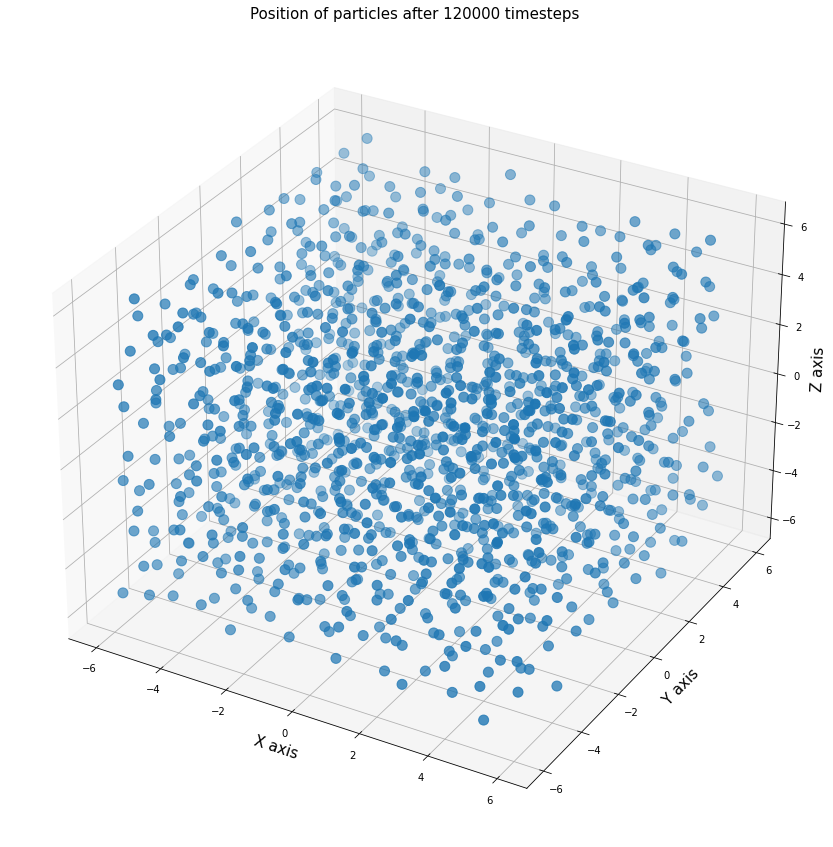

In [70]:
#plot the generated particle positions
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(b[-1,:,0],b[-1,:,1],b[-1,:,2], marker='o',s=100)
ax.set_xlabel('X axis', fontsize=15)
ax.set_ylabel('Y axis', fontsize=15)
ax.set_zlabel('Z axis', fontsize=15)
plt.title('Position of particles after 120000 timesteps', fontsize=15)
plt.show()

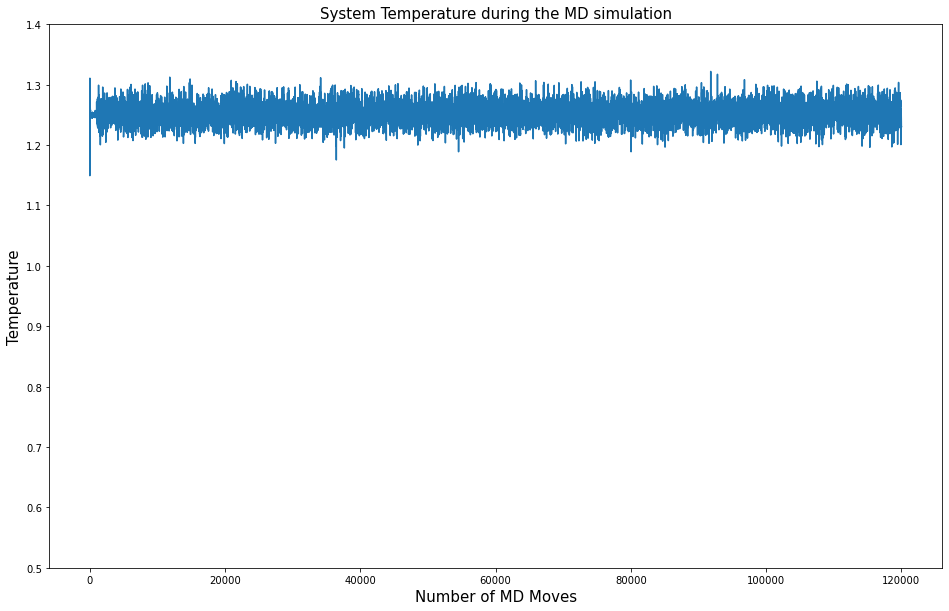

In [76]:
plt.figure(figsize=(16,10))
plt.plot(a[:,0],a[:,1])
plt.xlabel('Number of MD Moves', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('System Temperature during the MD simulation', fontsize=15)
plt.ylim((0.5, 1.4))
plt.show()

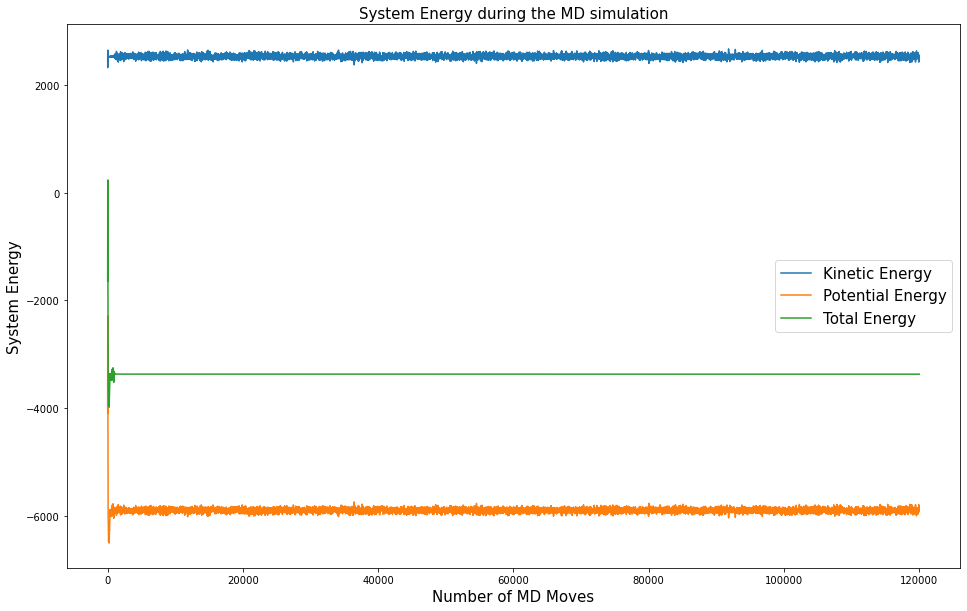

In [140]:
plt.figure(figsize=(16,10))
plt.plot(a[:,0],a[:,2], label= 'Kinetic Energy')
plt.plot(a[:,0],a[:,3],label= 'Potential Energy')
plt.plot(a[:,0],a[:,4],label= 'Total Energy')
plt.xlabel('Number of MD Moves', fontsize=15)
plt.ylabel('System Energy', fontsize=15)
plt.title('System Energy during the MD simulation', fontsize=15)
plt.legend(fontsize=15)
plt.show()

It took approximately 1000 +/-500 MD steps for the system to equilibrate

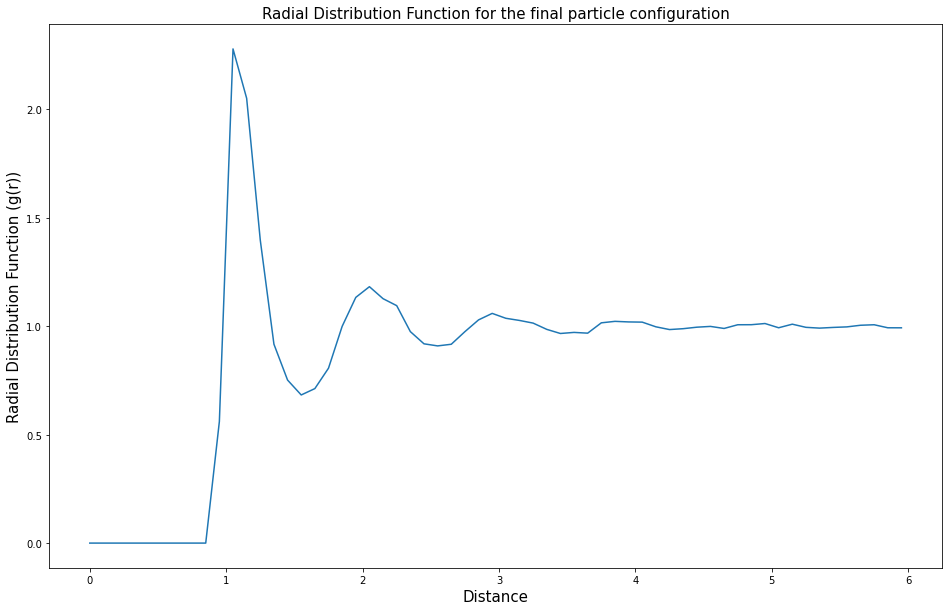

In [151]:
#Ploting the RDF for the final particle configuration
num_shells=box_L*5
r=box_L/2
co_od = b[-1]
ri,g_r,dr,Id_rdf,cal_rdf = get_g(num_part,num_shells, r, co_od,rho)
plt.figure(figsize=(16,10))
plt.plot(ri, g_r)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Radial Distribution Function (g(r))', fontsize=15)
plt.title('Radial Distribution Function for the final particle configuration', fontsize=15)
plt.show()

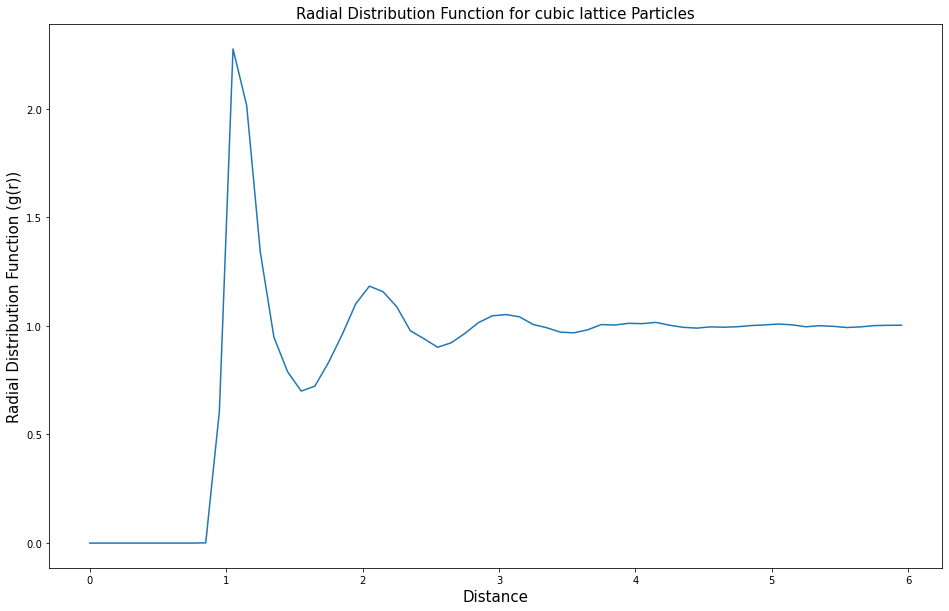

In [69]:
#Ploting the average RDF for the last 200 particle configuration
num_shells=box_L*5
r=box_L/2
g_r_list = []
for i in range(200):
    co_od = b[-i]
    ri,g_r,dr,Id_rdf,cal_rdf = get_g(num_part,num_shells, r, co_od,rho)
    g_r_list.append(g_r)
g_r_list = np.array(g_r_list)
g_r_avg = np.average(g_r_list,axis=0)
plt.figure(figsize=(16,10))
plt.plot(ri, g_r_avg)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Radial Distribution Function (g(r))', fontsize=15)
plt.title('Average RDF for the last 200 particle configuration', fontsize=15)
plt.show()

In [110]:
E003,q=read_file(filename="data.txt")
E0005,q=read_file(filename="./Documents/MD/0005/data.txt")
E002,q=read_file(filename="./Documents/MD/002/data.txt")
E005,q=read_file(filename="./Documents/MD/005/data.txt")
E01,q=read_file(filename="./Documents/MD/010/data.txt")

In [116]:
def RMSEF(TE):
    E_rms = np.sqrt(np.mean(np.square(TE[:,4][-1000:-1] - np.mean(TE[:,4][-1000:-1]))))
    #E_rms = np.sqrt(np.mean(np.square(a[:,4] - np.mean(a[:,4]))))
    return E_rms

In [117]:
log_t = np.log10(np.array([0.0005,0.002,0.003,0.005,0.01]))
log_RMSF = np.log10(np.array([RMSEF(E0005),RMSEF(E002),RMSEF(E003),RMSEF(E005),RMSEF(E01)]))

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(log_t,log_RMSF)
m, b = np.polyfit(log_t,log_RMSF, 1)
#add linear regression line to scatterplot 
#plt.plot(log_t, m*log_t+b)
plt.xlabel('Log of magnitude of MD time step', fontsize=15)
plt.ylabel('Log of root mean square fluctuation in Energy (RMSFE)', fontsize=15)
plt.title('Log-Log plot of RMSFE vs magnitude of time step ', fontsize=15)
plt.show()